In [1]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [15]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 1

# Training 수
epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

## 디렉토리 경로 설정 필요!!

In [16]:
# 디렉토리 경로 설정 필요
CurrentDirectory = "./"

train_directory = CurrentDirectory + 'TRAIN/'
test_directory  = CurrentDirectory + 'TEST/'
model_directory = CurrentDirectory + 'MODEL/'
tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [86]:
# 모델 Return
VGGModel = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
x = GlobalAveragePooling2D()(VGGModel.output)
predictions = Dense(2, activation='softmax')(x)

DeepLearning = Model(inputs=VGGModel.input, outputs=predictions)

# learning parameter를 더하여 최종 model compile
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
)

In [87]:
# 학습하지 않았으므로, 강사가 학습한 모델 사용
DeepLearning.load_weights(model_directory+'PretrainedVGG.hdf5')

In [96]:
GENERATOR = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

DATA_GENERATOR = GENERATOR.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    classes=["akiec", "melanoma"],
    class_mode= "categorical")

Found 60 images belonging to 2 classes.


 3/16 [====>.........................] - ETA: 51s - loss: 0.6923 - acc: 0.5417

https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=ko

# GradCam visualization 시각화 Heatmap

In [91]:
import PIL

def grad_cam(model, img, layer_name="block5_conv3", label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.Model(inputs=[model.inputs], outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap), predictions

def grad_camAll(model, img, layer_name="conv4_block6_out", blockSize=7, label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    res = sp.ndimage.zoom(conv_output[0], (224/blockSize, 224/blockSize, 1), order=2)   
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, res), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap)

def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = PIL.Image.fromarray(superimposed_img)  
    display(imgwithheat)

    if return_array:
        return superimposed_img

In [92]:
DeepLearning.summary()

Model: "model_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

[[1. 0.]]


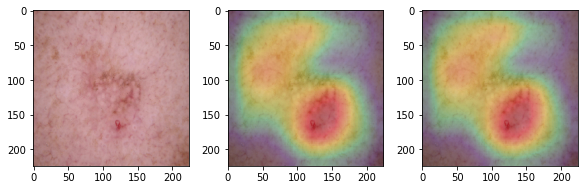

In [118]:
Iterator = 4

# item 받아오기
Image, Label = DATA_GENERATOR.__getitem__(Iterator)
Image = Image[0]
print(Label)


# grad_cam을 활용하여 heatmap 가져오기
HEATMAP1, pred1 = grad_cam(model = DeepLearning, img = Image, layer_name = 'block5_conv3', category_id=0)
heatmap_resize = cv2.resize(HEATMAP1, (224, 224))
heatmap_resize_255 = (heatmap_resize*255).astype("uint8")
heatmap1 = cv2.applyColorMap(255-heatmap_resize_255, cv2.COLORMAP_JET ) / 255
heatmap1[:, :, 2] -= .5
heatmap1[(heatmap1[:, :, 2] < 0), 2] = 0

fig, ax = plt.subplots( nrows=3, ncols=1 )  # create figure & 1 axis
fig.set_size_inches(9.0, 3.0)
ax = plt.subplot(1,3,1)
ax.imshow(Image)
ax = plt.subplot(1,3,2)
ax.imshow(Image)
ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
ax = plt.subplot(1,3,3)
ax.imshow(Image)
ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

plt.subplots_adjust(left = 0.06, wspace = 0.25, hspace = 0.1, bottom = 0.025, top = 0.975)
pred=round(pred1.numpy()[0][0],3)
plt.show()

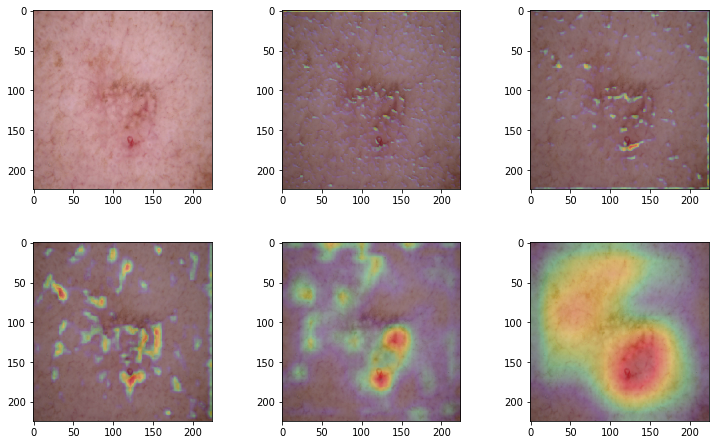

In [116]:
Image, Label = DATA_GENERATOR.__getitem__(Iterator)
Image = Image[0]
FileName = DATA_GENERATOR.filenames[Iterator]

LayerNames = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
Heatmaps = []
for LayerIDX in range(0, len(LayerNames)):
    HEATMAP1, pred1 = grad_cam(model = DeepLearning, img = Image, layer_name = LayerNames[LayerIDX], category_id=0)
    heatmap_resize = cv2.resize(HEATMAP1, (224, 224))
    heatmap_resize_255 = (heatmap_resize*255).astype("uint8")
    heatmap1 = cv2.applyColorMap(255-heatmap_resize_255, cv2.COLORMAP_JET ) / 255
    heatmap1[:, :, 2] -= .5
    heatmap1[(heatmap1[:, :, 2] < 0), 2] = 0
    Heatmaps.append(heatmap1)

fig, ax = plt.subplots( nrows=3, ncols=2 )  # create figure & 1 axis
fig.set_size_inches(18.0, 6.0)
ax = plt.subplot(2,3,1)
ax.imshow(Image)
ax = plt.subplot(2,3,2)
ax.imshow(Image)
ax.imshow(Heatmaps[0], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
ax = plt.subplot(2,3,3)
ax.imshow(Image)
ax.imshow(Heatmaps[1], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

ax = plt.subplot(2,3,4)
ax.imshow(Image)
ax.imshow(Heatmaps[2], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
ax = plt.subplot(2,3,5)
ax.imshow(Image)
ax.imshow(Heatmaps[3], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
ax = plt.subplot(2,3,6)
ax.imshow(Image)
ax.imshow(Heatmaps[4], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

plt.subplots_adjust(left = 0.06, wspace = -0.58, hspace = 0.3, bottom = 0.025, top = 0.975)

plt.show()